In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [8]:
df.shape

(10409, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [10]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
# --- 1. Data Preparation ---

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Sort by date, just in case
df.sort_index(inplace=True)

# Select the 'Adj Close' price
prices = df['Adj Close']

# Get the last price and date for reference
last_price = prices.iloc[-1]
last_date = prices.index[-1].strftime('%Y-%m-%d')
print(f"Starting simulation from: Date={last_date}, Price=${last_price:.2f}\n")


Starting simulation from: Date=2022-03-24, Price=$174.07



In [12]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1))

# Drop NaN values (the first one)
log_returns = log_returns.dropna()

# --- 2. Calculate Drift and Volatility ---

# Calculate mean (mu) and volatility (sigma) of log returns
mu = log_returns.mean()
sigma = log_returns.std()

# Calculate the drift component
# Drift = mu - 0.5 * sigma^2
drift = mu - 0.5 * (sigma**2)

print(f"--- Model Parameters ---")
print(f"Log Return Mean (mu): {mu:.6f}")
print(f"Log Return Volatility (sigma): {sigma:.6f}")
print(f"Drift: {drift:.6f}\n")


--- Model Parameters ---
Log Return Mean (mu): 0.000717
Log Return Volatility (sigma): 0.028800
Drift: 0.000302



In [13]:
# --- 3. Set Simulation Parameters ---
num_trials = 1000  # Number of simulations
num_days = 252     # Number of trading days to predict (approx. 1 year)

# --- 4. Run Monte Carlo Simulation ---

# Generate random standard normal shocks
# Shape: (num_days, num_trials)
shocks = np.random.normal(loc=0, scale=1, size=(num_days, num_trials))

# Calculate daily returns using Geometric Brownian Motion
# Daily Return = exp(drift + sigma * Z)
# where Z is the random shock
daily_returns = np.exp(drift + sigma * shocks)

# Initialize array to hold all price paths
# Shape: (num_days + 1, num_trials)
# We add +1 to include the starting price (S0)
paths = np.zeros((num_days + 1, num_trials))

# Set the starting price for all trials
S0 = last_price
paths[0, :] = S0

# Calculate price paths using cumulative product of daily returns
# paths[t] = paths[t-1] * daily_return[t]
# This is vectorized as S_t = S0 * cumprod(daily_returns)
paths[1:, :] = S0 * np.cumprod(daily_returns, axis=0)


In [21]:
# --- 5. Analyze Final Price Distribution ---

# Get the prices at the end of the simulation (final day)
final_prices = paths[-1, :]

print(f"--- Prediction Results for Day {num_days} ---")
print(f"\nMean Predicted Price: ${np.mean(final_prices):.2f}")
print(f"Median (50th Percentile) Price: ${np.median(final_prices):.2f}")
print("-" * 45)
print(f"\n5th Percentile Price: ${np.percentile(final_prices, 5):.2f}")
print(f"95th Percentile Price: ${np.percentile(final_prices, 95):.2f}\n")


--- Prediction Results for Day 252 ---

Mean Predicted Price: $212.32
Median (50th Percentile) Price: $188.25
---------------------------------------------

5th Percentile Price: $90.77
95th Percentile Price: $400.75



Text(0.1, 0.01, 'Starting Price: $174.07. Historical Volatility: 0.0288, Drift: 0.000302')

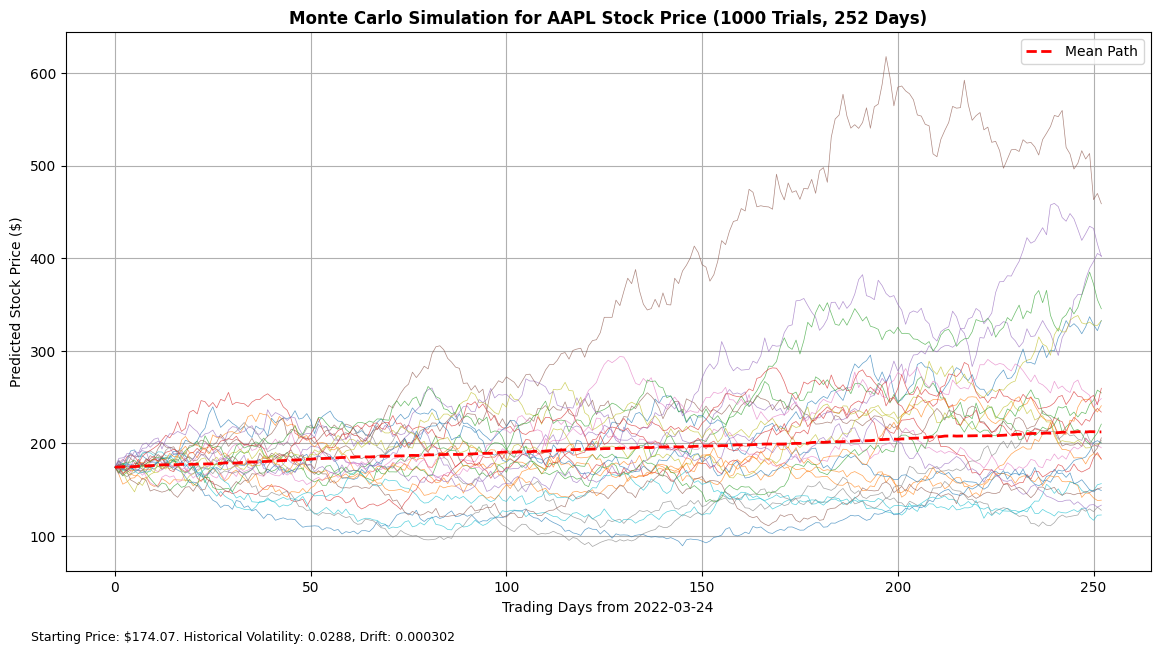

In [20]:
# --- 6. Plot Simulation Results ---

plt.figure(figsize=(14, 7))

# Plot the first 100 paths for clarity
plt.plot(paths[:, :26], linewidth=0.5, alpha=0.7)

# Plot the mean path
plt.plot(paths.mean(axis=1), color='red', linewidth=2, linestyle='--', label='Mean Path')

plt.title(f'Monte Carlo Simulation for AAPL Stock Price ({num_trials} Trials, {num_days} Days)',fontweight='bold')
plt.xlabel(f'Trading Days from {last_date}')
plt.ylabel('Predicted Stock Price ($)')
plt.legend()
plt.grid(True)
plt.figtext(0.1, 0.01, f'Starting Price: ${S0:.2f}. Historical Volatility: {sigma:.4f}, Drift: {drift:.6f}', ha='left', fontsize=9)
